In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
"""
from fast_gen import *
from learner import *
from pt_models import *
from dataset_pt import *
from sgdr_pt import *
"""
from fastai.conv_learner import *
from planet import *

In [4]:
project_name = 'planet-understanding-the-amazon-from-space'

In [22]:
PATH='/home/paperspace/data/planet/'

In [23]:
arch=resnet50
size=64
bs=64
metrics=[f2]

In [35]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [25]:
label_csv = f'{PATH}train_v2.csv'

In [26]:
no_of_rows = len(list(open(label_csv)))-1

In [27]:
val_idxs = get_cv_idxs(no_of_rows)

In [28]:
print(val_idxs.shape)
val_idxs

(8095,)


array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [29]:
label_df = pd.read_csv(label_csv)

In [30]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [33]:
label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)[:10]

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [36]:
data = get_data(size)

In [37]:
x, y = next(iter(data.val_dl))

In [38]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [39]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

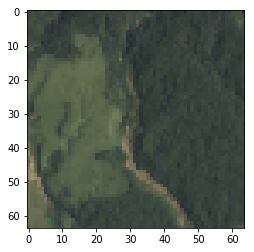

In [40]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

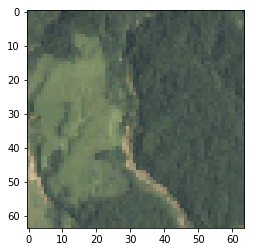

In [41]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] * 1.3 ) # TIP : Multiply by a value if the image is too hazy

In [42]:
data = get_data(size)

In [44]:
data = data.resize(int(size*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

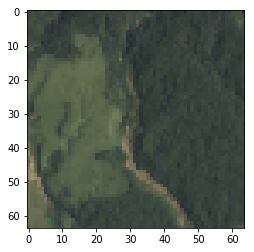

In [45]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

## Train model

In [47]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [48]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.225707   0.334274   0.77313   



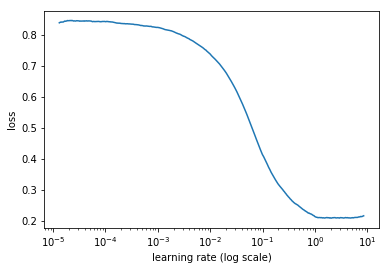

In [49]:
learn.sched.plot()

In [50]:
learning_rate = 0.2

In [51]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.146726   0.133824   0.880739  
    1      0.139048   0.128977   0.886925                    
    2      0.133264   0.125669   0.890008                    
    3      0.138006   0.12539    0.89087                     
    4      0.133989   0.123061   0.891594                    
    5      0.128251   0.121385   0.894549                    
    6      0.127373   0.121241   0.895029                    



[0.12124059, 0.8950288754571044]

##### As sat images are not part of imagnet, we divide by smaller numbers as we want to train the entire network from scratch. Well kind of, we initially use the weights from imagnet model as something is better than nothing and also, imagnet initial layers actually detect basic structures like edges etc.

In [ ]:
learn.sched.plot_loss()

In [54]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate]) 

In [55]:
learn.unfreeze()

In [56]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.11452    0.10682    0.907816  
    1      0.110477   0.102186   0.914154                    
    2      0.10552    0.098082   0.918442                    
    3      0.109006   0.104773   0.908302                    
    4      0.102628   0.100106   0.916582                    
    5      0.097605   0.095703   0.920222                     
    6      0.094115   0.095546   0.919903                     

CPU times: user 11min 35s, sys: 4min 8s, total: 15min 44s
Wall time: 13min 22s


[0.09554622, 0.9199029785189883]

In [59]:
%time learn.save(f'{project_name}_last_layer_{size}')

CPU times: user 20 ms, sys: 84 ms, total: 104 ms
Wall time: 101 ms


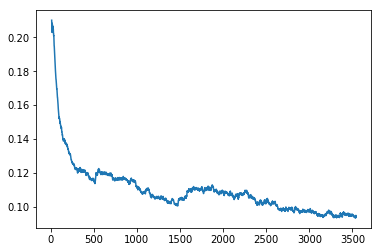

In [60]:
learn.sched.plot_loss()

### Increase pic size

In [61]:
size = 128

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.097945   0.092566   0.920806  
    1      0.093414   0.091352   0.922667                     
    2      0.093144   0.090884   0.922788                     
    3      0.092269   0.090649   0.921729                     
    4      0.091856   0.089895   0.924178                     
    5      0.091597   0.089068   0.92526                      
    6      0.091841   0.089778   0.924582                     

CPU times: user 21min 8s, sys: 3min 41s, total: 24min 50s
Wall time: 11min 25s


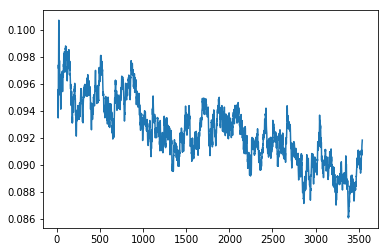

In [62]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

In [ ]:
learn.unfreeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.09606    0.088134   0.925503  
    1      0.094795   0.089023   0.925505                     
    2      0.089709   0.08484    0.929667                     
 36%|███▌      | 182/506 [01:28<02:36,  2.06it/s, loss=0.0968]

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)